In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [2]:
orders = pd.read_parquet('orders.parquet')
tips = pd.read_csv('tips_public.csv')
tips_t = pd.read_csv('tip_testdaten_template.csv')
order_product = pd.read_csv('order_products_denormalized.csv')

## Aufgab 2 a-c

##### NANs nach jedem User einfügen

In [3]:
def insert_nan_rows_after_user_change_vectorized(df: pd.DataFrame, nan_werte: int = 10) -> pd.DataFrame:
    df = df.copy()
    df.sort_values(["user_id", "order_date"], inplace=True)

    # Finde Start-Indices jedes neuen Users
    user_change_indices = df['user_id'].ne(df['user_id'].shift()).to_numpy().nonzero()[0][1:]

    # Liste aller Positionen, an denen wir NaN-Zeilen einfügen wollen
    insert_positions = []
    for idx in user_change_indices:
        insert_positions.extend([idx + i * nan_werte for i in range(1, 2)])

    # Ergebnis vorbereiten
    df_list = []
    last_idx = 0

    for pos in user_change_indices:
        df_list.append(df.iloc[last_idx:pos])
        # nan_werte viele leere Zeilen anhängen
        df_list.append(pd.DataFrame(np.nan, index=range(nan_werte), columns=df.columns))
        last_idx = pos

    # Rest anhängen
    df_list.append(df.iloc[last_idx:])

    return pd.concat(df_list, ignore_index=True)
#user_tip_with_gaps = insert_nan_rows_after_user_change_vectorized(user_tip, nan_werte=10)

In [ ]:
# df ohne enfternte bestellungen mit NaN Werten
m_order_tip = orders.merge(tips, how="inner", on="order_id")

# verkleinern des DFs für bessere Performance
m_order_tip_slice = m_order_tip[m_order_tip['user_id'] <= 80000]

## AR-Modelle

### a. AR(1)-Modell
Genauigkeit AR(1): 0.7327
AUC-ROC AR(1): 0.7317


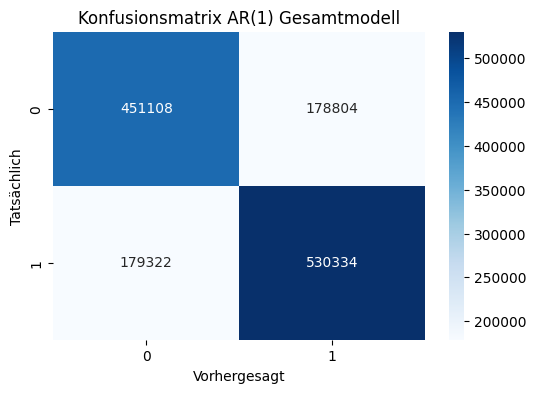


### b. AR(2)-Modell
Genauigkeit AR(2): 0.7330
AUC-ROC AR(2): 0.7778


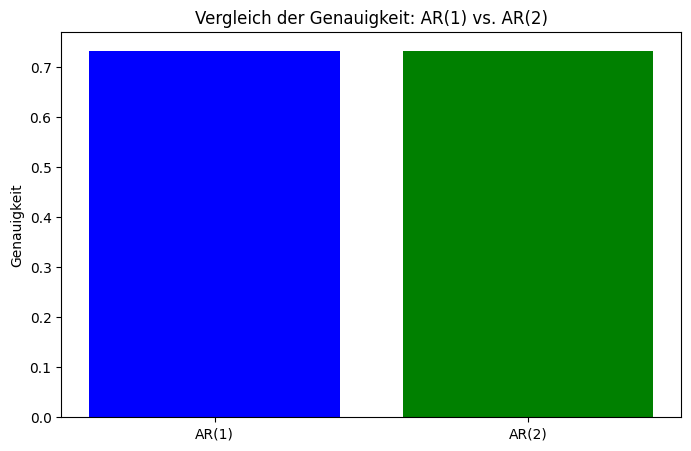


### c. Autokorrelation und optimales AR(n)-Modell (Alle Nutzer mit NaN-Lücken)
Länge der Zeitreihe (ohne NaN): 547534


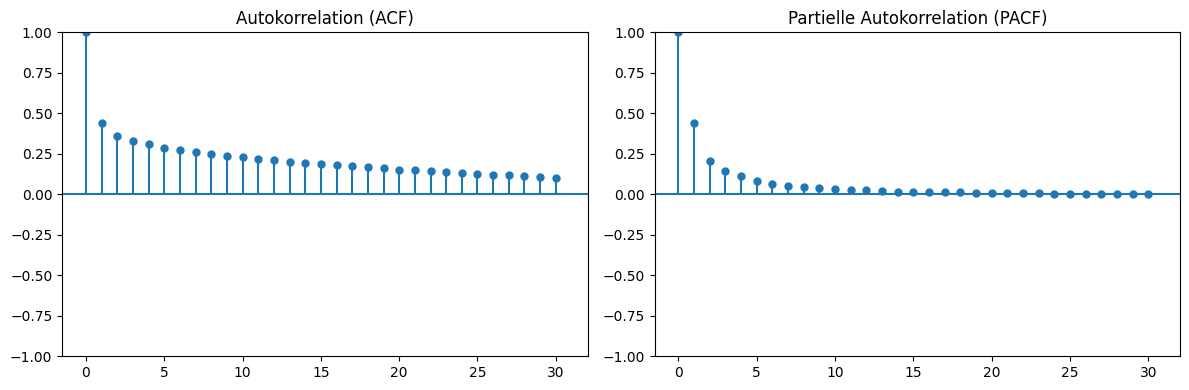

Optimale AR-Ordnung basierend auf PACF: 29
Genauigkeit AR(29): 0.7519
AUC-ROC AR(29): 0.8385


In [32]:
# Sicherstellen, dass die Daten nach user_id und order_date sortiert sind
m_order_tip = m_order_tip.sort_values(['user_id', 'order_date']).reset_index(drop=True)

# Funktion zur Erstellung verzögerter Variablen pro Nutzer
def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for lag in range(1, lags + 1):
        df_lagged[f'tip_lag{lag}'] = df_lagged.groupby('user_id')['tip'].shift(lag)
    return df_lagged

# a. AR(1)-Modell (Gesamtmodell)
print("### a. AR(1)-Modell")
df_ar1 = create_lagged_features(m_order_tip, lags=1)
df_ar1 = df_ar1.dropna()  # Entferne NaN-Werte

# Prüfe Klassenvielfalt
if len(np.unique(df_ar1['tip'])) < 2:
    print("Fehler: Nur eine Klasse in den Daten vorhanden.")
else:
    X_ar1 = df_ar1[['tip_lag1']]
    y_ar1 = df_ar1['tip']
    model_ar1 = LogisticRegression(solver='liblinear')
    model_ar1.fit(X_ar1, y_ar1)
    y_pred_ar1 = model_ar1.predict(X_ar1)
    accuracy_ar1 = accuracy_score(y_ar1, y_pred_ar1)
    auc_ar1 = roc_auc_score(y_ar1, model_ar1.predict_proba(X_ar1)[:, 1])
    print(f"Genauigkeit AR(1): {accuracy_ar1:.4f}")
    print(f"AUC-ROC AR(1): {auc_ar1:.4f}")

    # Visualisierung: Konfusionsmatrix
    cm_ar1 = confusion_matrix(y_ar1, y_pred_ar1)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_ar1, annot=True, fmt='d', cmap='Blues')
    plt.title('Konfusionsmatrix AR(1) Gesamtmodell')
    plt.xlabel('Vorhergesagt')
    plt.ylabel('Tatsächlich')
    plt.show()

# b. AR(2)-Modell (Gesamtmodell)
print("\n### b. AR(2)-Modell")
df_ar2 = create_lagged_features(m_order_tip, lags=2)
df_ar2 = df_ar2.dropna()

if len(np.unique(df_ar2['tip'])) < 2:
    print("Fehler: Nur eine Klasse in den Daten vorhanden.")
else:
    X_ar2 = df_ar2[['tip_lag1', 'tip_lag2']]
    y_ar2 = df_ar2['tip']
    model_ar2 = LogisticRegression(solver='liblinear')
    model_ar2.fit(X_ar2, y_ar2)
    y_pred_ar2 = model_ar2.predict(X_ar2)
    accuracy_ar2 = accuracy_score(y_ar2, y_pred_ar2)
    auc_ar2 = roc_auc_score(y_ar2, model_ar2.predict_proba(X_ar2)[:, 1])
    print(f"Genauigkeit AR(2): {accuracy_ar2:.4f}")
    print(f"AUC-ROC AR(2): {auc_ar2:.4f}")

    # Visualisierung: Vergleich AR(1) vs. AR(2)
    plt.figure(figsize=(8, 5))
    plt.bar(['AR(1)', 'AR(2)'], [accuracy_ar1, accuracy_ar2], color=['blue', 'green'])
    plt.title('Vergleich der Genauigkeit: AR(1) vs. AR(2)')
    plt.ylabel('Genauigkeit')
    plt.show()

print("\n### c. Autokorrelation und optimales AR(n)-Modell (Alle Nutzer mit NaN-Lücken)")

# Daten mit NaN-Zeilen zwischen Nutzern vorbereiten
user_tip_with_gaps = insert_nan_rows_after_user_change_vectorized(m_order_tip_slice, nan_werte=10)

# Konvertiere 'tip'-Spalte zu numerisch, NaN für ungültige Werte
user_tip_with_gaps['tip'] = pd.to_numeric(user_tip_with_gaps['tip'], errors='coerce')

# Zeitreihe der Tipps (mit NaN-Werten)
tip_series = user_tip_with_gaps['tip'].values

# Entferne NaN-Werte für ACF/PACF-Berechnung
tip_series_nonan = tip_series[~np.isnan(tip_series)]

# Überprüfe, ob genügend Datenpunkte vorhanden sind
min_data_points = 12  # Mindestens 12 Datenpunkte für nlags=10
if len(tip_series_nonan) < min_data_points:
    print("Fehler: Nicht genügend Datenpunkte für ACF/PACF (>= 12).")
else:
    print(f"Länge der Zeitreihe (ohne NaN): {len(tip_series_nonan)}")

    # Dynamisch nlags anpassen (maximal 50% der Zeitreihenlänge)
    max_lags = min(30, len(tip_series_nonan) // 2)  # Maximal 10 oder 50% der Länge
    if max_lags < 1:
        print("Fehler: Zeitreihe zu kurz für ACF/PACF.")
    else:
        # ACF und PACF berechnen
        acf_vals = acf(tip_series_nonan, nlags=max_lags, fft=False)
        pacf_vals = pacf(tip_series_nonan, nlags=max_lags)

        # Visualisierung
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plot_acf(tip_series_nonan, lags=max_lags, ax=plt.gca())
        plt.title('Autokorrelation (ACF)')
        plt.subplot(1, 2, 2)
        plot_pacf(tip_series_nonan, lags=max_lags, ax=plt.gca())
        plt.title('Partielle Autokorrelation (PACF)')
        plt.tight_layout()
        plt.show()

        # Bestimme optimale Ordnung n basierend auf PACF
        significant_lags = np.where(np.abs(pacf_vals) > 1.96/np.sqrt(len(tip_series_nonan)))[0]
        n_optimal = max(significant_lags) if len(significant_lags) > 0 else 1
        print(f"Optimale AR-Ordnung basierend auf PACF: {n_optimal}")

        # Fitte AR(n_optimal)-Modell auf gesamte Daten mit NaN-Lücken
        df_arn = create_lagged_features(user_tip_with_gaps, lags=n_optimal)
        df_arn = df_arn.dropna()

        if len(np.unique(df_arn['tip'])) < 2:
            print(f"Fehler: Nur eine Klasse in den Daten vorhanden für AR({n_optimal}).")
        else:
            X_arn = df_arn[[f'tip_lag{i}' for i in range(1, n_optimal + 1)]]
            y_arn = df_arn['tip']
            model_arn = LogisticRegression(solver='liblinear')
            model_arn.fit(X_arn, y_arn)
            y_pred_arn = model_arn.predict(X_arn)
            accuracy_arn = accuracy_score(y_arn, y_pred_arn)
            auc_arn = roc_auc_score(y_arn, model_arn.predict_proba(X_arn)[:, 1])
            print(f"Genauigkeit AR({n_optimal}): {accuracy_arn:.4f}")
            print(f"AUC-ROC AR({n_optimal}): {auc_arn:.4f}")

## Aufgabe 2 d-e

## Periodizitäten

In [6]:
# ordercounter für jeden tag
order_count = orders[['order_date']].groupby(orders['order_date'].dt.date)['order_date'].count().reset_index(name='order_count')
#orders
#tips_p 
#tips_t 
#order_product

# pair month with correct season
def get_season_from_month_name(month_name):
    spring_months = ['March', 'April', 'May']
    summer_months = ['June', 'July', 'August']
    autumn_months = ['September', 'October', 'November']
    winter_months = ['December', 'January', 'February']
    
    
    if month_name in spring_months:
        return 'Spring'
    elif month_name in summer_months:
        return 'Summer'
    elif month_name in autumn_months:
        return 'Autumn'
    elif month_name in winter_months:
        return 'Winter'
    
# add collumns hour, day, month, season 
m_order_tip['hour'] = m_order_tip['order_date'].dt.hour
m_order_tip['day'] = m_order_tip['order_date'].dt.day_name()
m_order_tip['month'] = m_order_tip['order_date'].dt.month_name()
m_order_tip['season'] = m_order_tip['month'].apply(get_season_from_month_name)

# correct order of days, months and seasons for plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
m_order_tip['day'] = pd.Categorical(m_order_tip['day'], categories=day_order, ordered=True)
mont_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
m_order_tip['month'] = pd.Categorical(m_order_tip['month'], categories=mont_order, ordered=True)
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
m_order_tip['season'] = pd.Categorical(m_order_tip['season'], categories=season_order, ordered=True)

# calculate probability of tip for each hour, day, month and season and convert to percentage
hour_prob = m_order_tip.groupby('hour')['tip'].mean().reset_index(name='tip_probability_hour')
hour_prob['tip_probability_hour'] = (hour_prob['tip_probability_hour']*100).round(2)
day_prob = m_order_tip.groupby('day', observed=False)['tip'].mean().reset_index(name='tip_probability_day')
day_prob['tip_probability_day'] = (day_prob['tip_probability_day']*100).round(2)
month_prob = m_order_tip.groupby('month', observed=False)['tip'].mean().reset_index(name='tip_probability_month')
month_prob['tip_probability_month'] = (month_prob['tip_probability_month']*100).round(2)
season_prob = m_order_tip.groupby('season', observed=False)['tip'].mean().reset_index(name='tip_probability_season')
season_prob['tip_probability_season'] = (season_prob['tip_probability_season']*100).round(2)

month_prob

,month,tip_probability_month
0,January,54.09
1,February,51.32
2,March,51.46
3,April,50.50
4,May,51.42
5,June,53.70
6,July,52.70
7,August,53.76
8,September,54.89
9,October,54.12


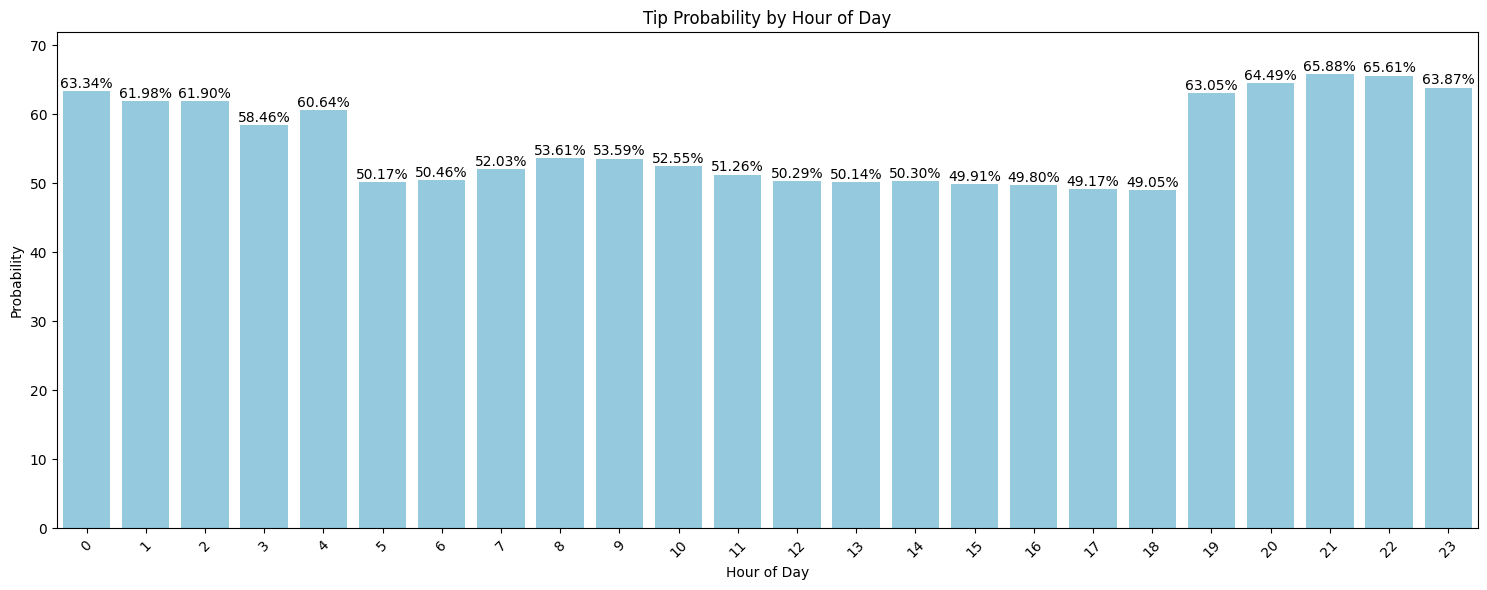

In [7]:
plt.figure(figsize=(15, 6))
ax1 = sns.barplot(x='hour', y='tip_probability_hour', data=hour_prob, color='skyblue')

for i, bar in enumerate(ax1.patches):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # x-Position (Mitte des Balkens)
        height + 0.02,                      # y-Position (leicht über dem Balken)
        f'{height:.2f}%',                   # Wert, auf 2 Dezimalstellen formatiert in %
        ha='center',                        # Horizontale Ausrichtung: Mitte
        va='bottom',                        # Vertikale Ausrichtung: Unterkante
        fontsize=10,                        # Schriftgröße
        color='black'                       # Textfarbe
    )

plt.title('Tip Probability by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.ylim(0, max(hour_prob['tip_probability_hour']) + 6)
plt.tight_layout()
plt.show()

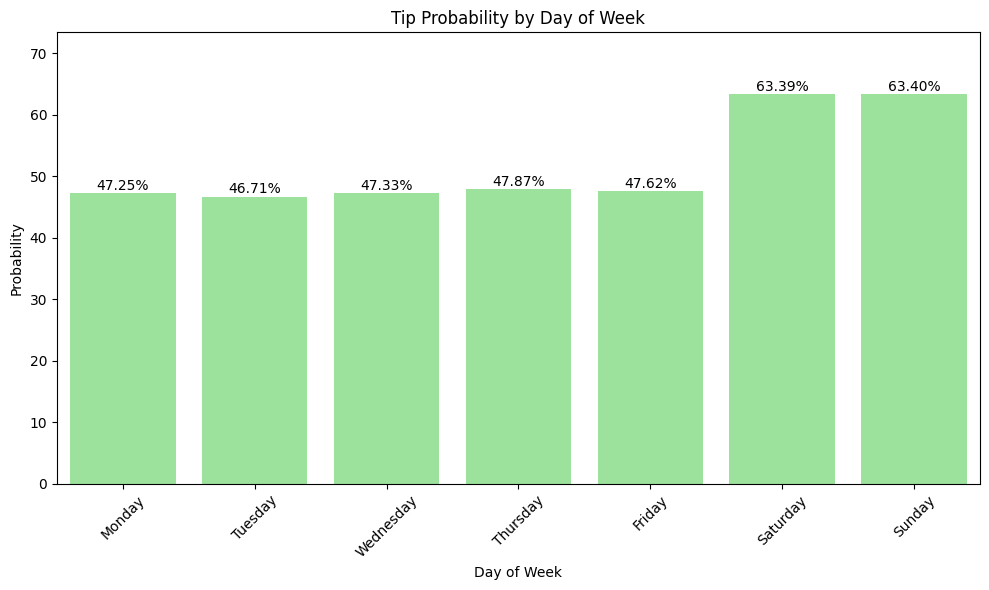

In [8]:
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(x='day', y='tip_probability_day', data=day_prob, color='lightgreen')

for i, bar in enumerate(ax2.patches):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # x-Position (Mitte des Balkens)
        height + 0.02,                      # y-Position (leicht über dem Balken)
        f'{height:.2f}%',                   # Wert, auf 2 Dezimalstellen formatiert in %
        ha='center',                        # Horizontale Ausrichtung: Mitte
        va='bottom',                        # Vertikale Ausrichtung: Unterkante
        fontsize=10,                        # Schriftgröße
        color='black'                       # Textfarbe
    )

plt.title('Tip Probability by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.ylim(0, max(day_prob['tip_probability_day']) + 10)
plt.tight_layout()
plt.show()

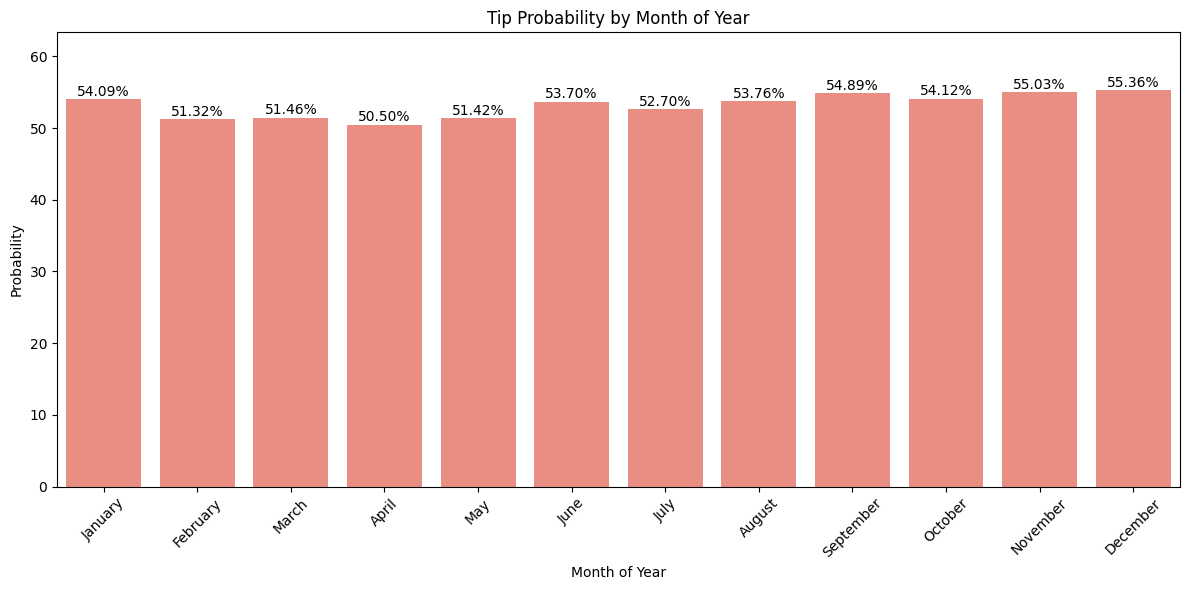

In [9]:
plt.figure(figsize=(12, 6))
ax3 = sns.barplot(x='month', y='tip_probability_month', data=month_prob, color='salmon')

for i, bar in enumerate(ax3.patches):
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2,  # x-Position (Mitte des Balkens)
        height + 0.02,                      # y-Position (leicht über dem Balken)
        f'{height:.2f}%',                   # Wert, auf 2 Dezimalstellen formatiert in %
        ha='center',                        # Horizontale Ausrichtung: Mitte
        va='bottom',                        # Vertikale Ausrichtung: Unterkante
        fontsize=10,                        # Schriftgröße
        color='black'                       # Textfarbe
    )

plt.title('Tip Probability by Month of Year')
plt.xlabel('Month of Year')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.ylim(0, max(month_prob['tip_probability_month']) + 8)
plt.tight_layout()
plt.show()

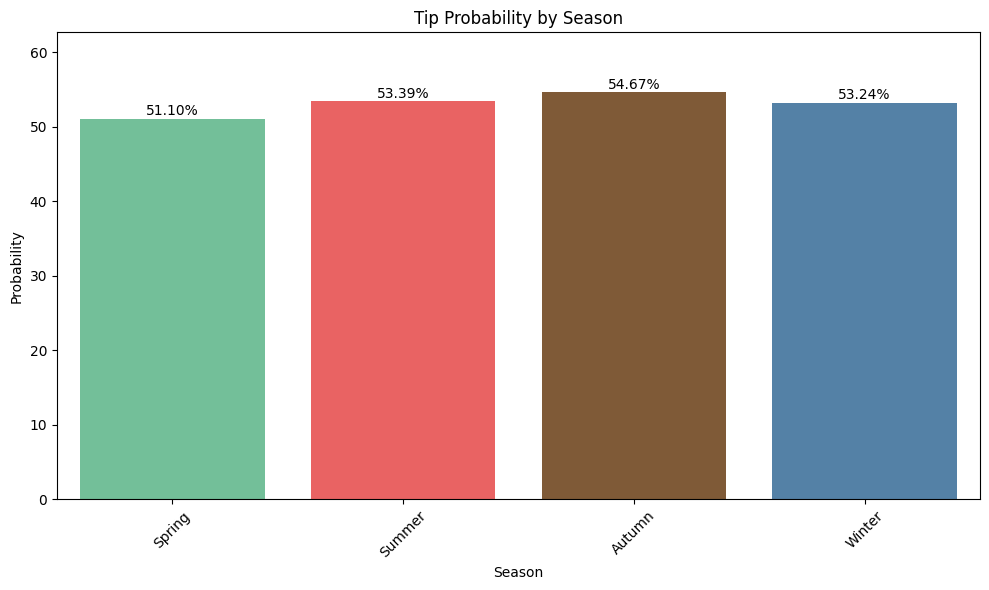

In [10]:
# Farben für jede Jahreszeit
colors = ['#66CC99', '#FF4D4D', '#8B5A2B', '#4682B4']  # Spring=grün, Summer=rot, Autumn=braun, Winter=blau

# Plot erstellen
plt.figure(figsize=(10, 6))
ax4 = sns.barplot(x='season', y='tip_probability_season', hue='season', data=season_prob, 
                 palette=colors, legend=False)

# Werte in die Balken einfügen
for i, bar in enumerate(ax4.patches):
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width() / 2,  # x-Position (Mitte des Balkens)
        height + 0.02,                      # y-Position (leicht über dem Balken)
        f'{height:.2f}%',                    # Wert, auf 2 Dezimalstellen formatiert
        ha='center',                        # Horizontale Ausrichtung: Mitte
        va='bottom',                        # Vertikale Ausrichtung: Unterkante
        fontsize=10,                        # Schriftgröße
        color='black'                       # Textfarbe
    )

plt.title('Tip Probability by Season')
plt.xlabel('Season')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.ylim(0, max(season_prob['tip_probability_season']) + 8)  # y-Achse anpassen für Textplatz
plt.tight_layout()
plt.show()

## Trends

In [11]:
orders_ext = orders.copy()
orders_ext['weeks_since_start'] = ((orders_ext['order_date'] - orders_ext['order_date'].min())
                                   .dt.total_seconds() / 60 / 60 / 24 / 7).astype(int)

orders_with_tips = orders_ext.merge(tips, on="order_id",how="inner")
orders_with_tips.head()

weekly_percentages = orders_with_tips.groupby("weeks_since_start").agg(total_orders=("order_id","count"), tipped_orders=("tip","sum"))
weekly_percentages["tip_percentage"] = 100*weekly_percentages["tipped_orders"] / weekly_percentages["total_orders"]
#weekly_percentages.tail()

weekly_percentages = weekly_percentages[weekly_percentages['total_orders']>= 1000]
weekly_percentages.head()

,total_orders,tipped_orders,tip_percentage
weeks_since_start,,,
0,3105,1454,46.827697
1,8006,3865,48.276293
2,12073,5925,49.076452
3,16439,8128,49.443397
4,20317,9962,49.032830


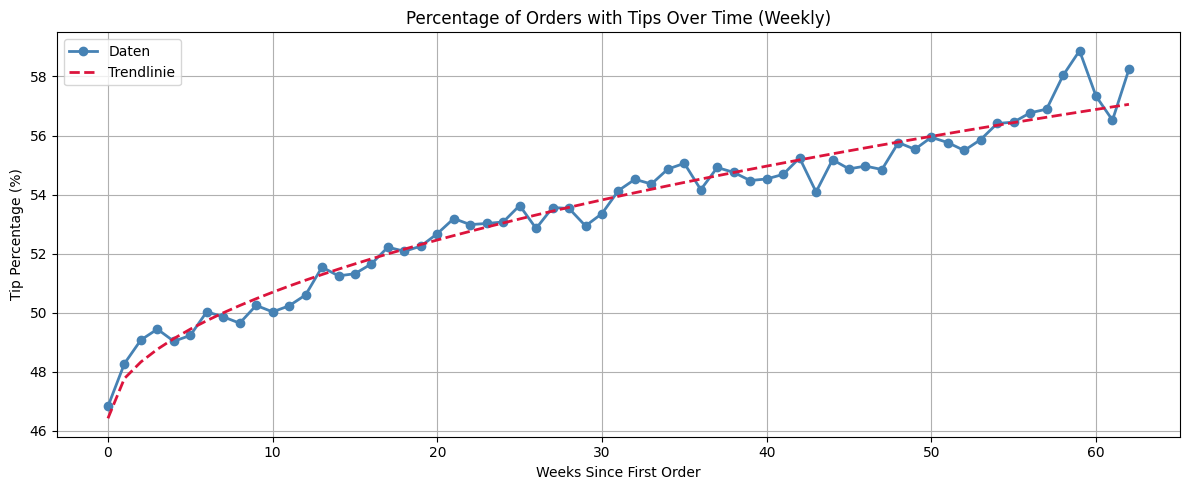

In [12]:
def sqrt_trend(x, a, b):
    return a + b * np.sqrt(x)

# Kurvenanpassung
popt, _ = curve_fit(sqrt_trend, weekly_percentages.index, weekly_percentages['tip_percentage'])
y_pred = sqrt_trend(weekly_percentages.index, *popt)

# Plot erstellen
plt.figure(figsize=(12, 5))

plt.plot(weekly_percentages.index, weekly_percentages['tip_percentage'], 
         marker='o', color='steelblue', linestyle='-', linewidth=2, label='Daten')

# Wurzeltrendlinie
plt.plot(weekly_percentages.index, y_pred, 
         color='crimson', linestyle='--', linewidth=2, label='Trendlinie')

# Plot-Anpassungen
plt.title('Percentage of Orders with Tips Over Time (Weekly)')
plt.xlabel('Weeks Since First Order')
plt.ylabel('Tip Percentage (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Aufgabe 2 f-g

#### f ) 


Autokorrelation und optimales AR(n)-Modell (Alle Nutzer mit NaN-Lücken)
Länge der Zeitreihe (ohne NaN): 547534


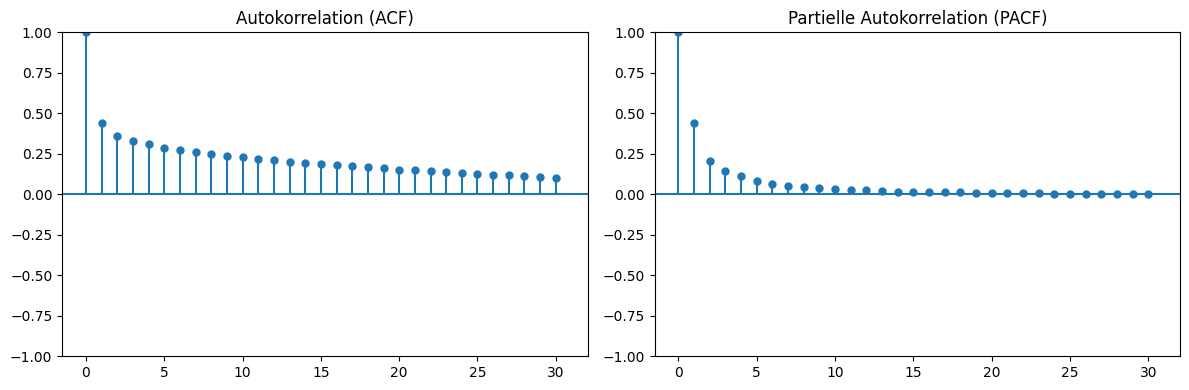

Optimale AR-Ordnung basierend auf PACF: 29
Genauigkeit AR(29): 0.7634
AUC-ROC AR(29): 0.8513


In [33]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definition der create_lagged_features-Funktion
def create_lagged_features(df: pd.DataFrame, lags: int) -> pd.DataFrame:
    df = df.copy()
    df.sort_values(["user_id", "order_date"], inplace=True)
    
    for i in range(1, lags + 1):
        df[f'tip_lag{i}'] = df.groupby('user_id')['tip'].shift(i)
    
    return df


print("\nAutokorrelation und optimales AR(n)-Modell (Alle Nutzer mit NaN-Lücken)")

# Daten mit NaN-Zeilen zwischen Nutzern vorbereiten
user_tip_with_gaps = insert_nan_rows_after_user_change_vectorized(m_order_tip_slice, nan_werte=10)

# Konvertiere 'tip'-Spalte zu numerisch, NaN für ungültige Werte
user_tip_with_gaps['tip'] = pd.to_numeric(user_tip_with_gaps['tip'], errors='coerce')

# Wochentag als Feature hinzufügen
user_tip_with_gaps['weekday'] = user_tip_with_gaps['order_date'].dt.dayofweek
weekday_dummies = pd.get_dummies(user_tip_with_gaps['weekday'], prefix='wd')
user_tip_with_gaps = pd.concat([user_tip_with_gaps, weekday_dummies], axis=1)

# Stunde als Feature 
user_tip_with_gaps['hour'] = user_tip_with_gaps['order_date'].dt.hour
hour_dummies = pd.get_dummies(user_tip_with_gaps['hour'], prefix='hour')
user_tip_with_gaps = pd.concat([user_tip_with_gaps, hour_dummies], axis=1)

# Zeitreihe der Tipps (mit NaN-Werten)
tip_series = user_tip_with_gaps['tip'].values

# Entferne NaN-Werte für ACF/PACF-Berechnung
tip_series_nonan = tip_series[~np.isnan(tip_series)]

# Überprüfe, ob genügend Datenpunkte vorhanden sind
min_data_points = 12  # Mindestens 12 Datenpunkte für nlags=10
if len(tip_series_nonan) < min_data_points:
    print("Fehler: Nicht genügend Datenpunkte für ACF/PACF (>= 12).")
else:
    print(f"Länge der Zeitreihe (ohne NaN): {len(tip_series_nonan)}")

    # Dynamisch nlags anpassen (maximal 50% der Zeitreihenlänge)
    max_lags = min(30, len(tip_series_nonan) // 2)  # Maximal 30 oder 50% der Länge
    if max_lags < 1:
        print("Fehler: Zeitreihe zu kurz für ACF/PACF.")
    else:
        # ACF und PACF berechnen
        acf_vals = acf(tip_series_nonan, nlags=max_lags, fft=False)
        pacf_vals = pacf(tip_series_nonan, nlags=max_lags)

        # Visualisierung
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plot_acf(tip_series_nonan, lags=max_lags, ax=plt.gca())
        plt.title('Autokorrelation (ACF)')
        plt.subplot(1, 2, 2)
        plot_pacf(tip_series_nonan, lags=max_lags, ax=plt.gca())
        plt.title('Partielle Autokorrelation (PACF)')
        plt.tight_layout()
        plt.show()

        # Bestimme optimale Ordnung n basierend auf PACF
        significant_lags = np.where(np.abs(pacf_vals) > 1.96/np.sqrt(len(tip_series_nonan)))[0]
        n_optimal = max(significant_lags) if len(significant_lags) > 0 else 1
        print(f"Optimale AR-Ordnung basierend auf PACF: {n_optimal}")

        # Fitte AR(n_optimal)-Modell auf gesamte Daten mit NaN-Lücken
        df_arn = create_lagged_features(user_tip_with_gaps, lags=n_optimal)

        #Feature-Spalten: Lags + Weekday dummies
        lag_cols = [f'tip_lag{i}' for i in range(1, n_optimal + 1)]
        weekday_cols = weekday_dummies.columns.tolist()
        hour_cols = [col for col in df_arn.columns if col.startswith('hour_')]
        # Drop NaN, insbesondere wegen Lag-Features
        df_arn = df_arn.dropna(subset=lag_cols)

        # Sicherstellen, dass Zielvariable vorhanden ist
        if len(np.unique(df_arn['tip'])) < 2:
            print(f"Fehler: Nur eine Klasse in den Daten vorhanden für AR({n_optimal}).")
        else:
            X_arn = df_arn[lag_cols + weekday_cols + hour_cols]
            y_arn = df_arn['tip']

            model_arn = LogisticRegression(solver='liblinear')
            model_arn.fit(X_arn, y_arn)
            y_pred_arn = model_arn.predict(X_arn)
            accuracy_arn = accuracy_score(y_arn, y_pred_arn)
            auc_arn = roc_auc_score(y_arn, model_arn.predict_proba(X_arn)[:, 1])
            print(f"Genauigkeit AR({n_optimal}): {accuracy_arn:.4f}")
            print(f"AUC-ROC AR({n_optimal}): {auc_arn:.4f}")

#### g )

In [ ]:
# df mit den NaN Werten der enfternten Bestellungen
merge_tip = pd.merge(orders, tips, on= 'order_id', how= 'left')


Autokorrelation und optimales AR(n)-Modell (Alle Nutzer mit NaN-Lücken)
Länge der Zeitreihe (ohne NaN): 547534


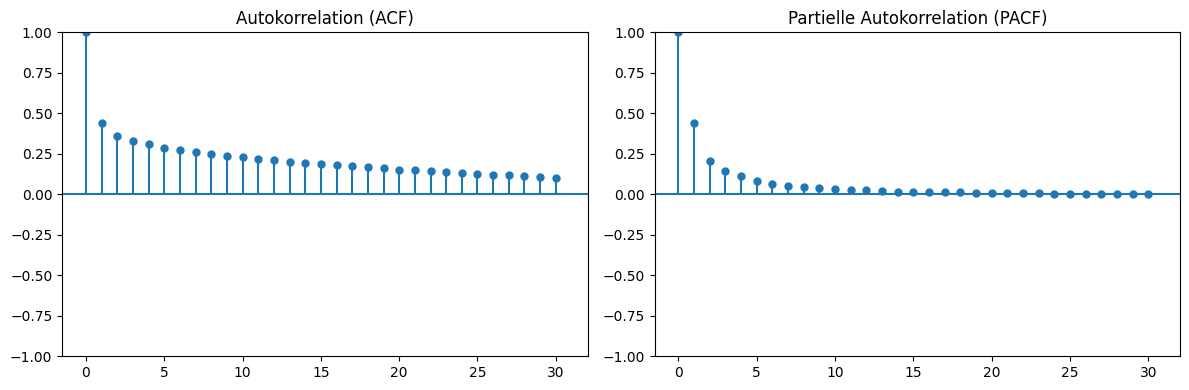

Optimale AR-Ordnung basierend auf PACF: 29
Genauigkeit AR(29): 0.7519
AUC-ROC AR(29): 0.8385

Debugging: df_with_lags für alle Zeilen:
         order_id  user_id          order_date  tip  tip_lag1  tip_lag2  \
0         1374495        3 2024-03-31 14:05:18  1.0       NaN       NaN   
1          444309        3 2024-04-09 19:45:51  1.0       1.0       NaN   
2         3002854        3 2024-04-30 16:25:20  1.0       1.0       1.0   
3         2037211        3 2024-05-20 18:31:28  1.0       1.0       1.0   
4         2710558        3 2024-06-01 17:52:27  1.0       1.0       1.0   
...           ...      ...                 ...  ...       ...       ...   
1463627   3059777   206208 2025-02-09 10:08:18  0.0       0.0       0.0   
1463628   2239861   206208 2025-02-18 04:40:09  1.0       0.0       0.0   
1463629   1285346   206208 2025-02-23 11:33:43  1.0       1.0       0.0   
1463630   1882108   206208 2025-03-02 22:18:46  1.0       1.0       1.0   
1463631    803273   206208 2025-03-06 11

In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Definition der create_lagged_features-Funktion
def create_lagged_features(df: pd.DataFrame, lags: int) -> pd.DataFrame:
    """
    Erstellt verzögerte Merkmale (Lags) für die 'tip'-Spalte pro Nutzer.
    
    Args:
        df (pd.DataFrame): DataFrame mit den Spalten 'user_id', 'order_date', 'tip'
        lags (int): Anzahl der Lags, die erstellt werden sollen
    
    Returns:
        pd.DataFrame: DataFrame mit zusätzlichen Spalten 'tip_lag1', 'tip_lag2', ..., 'tip_lagn'
    """
    df = df.copy()
    df.sort_values(["user_id", "order_date"], inplace=True)
    
    # Erstelle Lags pro user_id
    for i in range(1, lags + 1):
        df[f'tip_lag{i}'] = df.groupby('user_id')['tip'].shift(i)
    
    return df

# Definition der insert_nan_rows_after_user_change_vectorized-Funktion
def insert_nan_rows_after_user_change_vectorized(df: pd.DataFrame, nan_werte: int = 10) -> pd.DataFrame:
    df = df.copy()
    df.sort_values(["user_id", "order_date"], inplace=True)
    user_change_indices = df['user_id'].ne(df['user_id'].shift()).to_numpy().nonzero()[0][1:]
    insert_positions = []
    for idx in user_change_indices:
        insert_positions.extend([idx + i * nan_werte for i in range(1, 2)])
    df_list = []
    last_idx = 0
    for pos in user_change_indices:
        df_list.append(df.iloc[last_idx:pos])
        df_list.append(pd.DataFrame(np.nan, index=range(nan_werte), columns=df.columns))
        last_idx = pos
    df_list.append(df.iloc[last_idx:])
    return pd.concat(df_list, ignore_index=True)

# Funktion zur Vorhersage der Tipps für die letzten Bestellungen
def predict_last_orders_tips(df_new: pd.DataFrame, model, n_lags: int) -> pd.DataFrame:
    """
    Predictet die Tipps für die letzten Bestellungen jedes Nutzers, bei denen tip NaN ist.
    
    Args:
        df_new (pd.DataFrame): DataFrame mit historischen und neuen Bestellungen (tip=NaN für letzte Bestellungen)
        model: Trainiertes Modell (LogisticRegression)
        n_lags (int): Anzahl der Lags, die im Modell verwendet werden
    
    Returns:
        pd.DataFrame: df_new mit vorhergesagten tip-Werten und Wahrscheinlichkeiten für die letzten Bestellungen
    """
    df_new = df_new.copy()
    
    # Konvertiere 'tip'-Spalte zu numerisch
    df_new['tip'] = pd.to_numeric(df_new['tip'], errors='coerce')
    
    # Erstelle verzögerte Merkmale (ohne NaN-Zeilen für Vorhersage)
    df_with_lags = create_lagged_features(df_new, lags=n_lags)
    
    # Debugging: Zeige die Lags für die letzten Bestellungen
    print("\nDebugging: df_with_lags für alle Zeilen:")
    print(df_with_lags[['order_id', 'user_id', 'order_date', 'tip'] + [f'tip_lag{i}' for i in range(1, n_lags + 1)]])
    
    # Identifiziere die Zeilen, bei denen tip NaN ist (letzte Bestellungen)
    last_orders = df_with_lags[df_with_lags['tip'].isna()]
    
    # Debugging: Zeige die letzten Bestellungen
    print("\nDebugging: last_orders (Zeilen mit tip=NaN):")
    print(last_orders[['order_id', 'user_id', 'order_date', 'tip'] + [f'tip_lag{i}' for i in range(1, n_lags + 1)]])
    
    # Fülle fehlende Lags mit dem Mittelwert der tip-Werte
    lag_cols = [f'tip_lag{i}' for i in range(1, n_lags + 1)]
    if last_orders[lag_cols].isna().any().any():
        print("Warnung: Einige Lag-Merkmale enthalten NaN-Werte. Fülle mit Mittelwert.")
        mean_tip = df_new['tip'].mean()
        last_orders[lag_cols] = last_orders[lag_cols].fillna(mean_tip)
    
    # Entferne Zeilen mit NaN in den Lag-Merkmalen (sollte nach Auffüllen nicht vorkommen)
    last_orders = last_orders.dropna(subset=lag_cols)
    
    # Debugging: Zeige die finalen letzten Bestellungen
    print("\nDebugging: last_orders nach NaN-Auffüllen:")
    print(last_orders[['order_id', 'user_id', 'order_date', 'tip'] + lag_cols])
    
    # Extrahiere Features für Vorhersagen
    X_new = last_orders[lag_cols]
    
    # Mache Vorhersagen
    if not X_new.empty:
        y_pred_new = model.predict(X_new)
        y_pred_proba_new = model.predict_proba(X_new)[:, 1]  # Wahrscheinlichkeit für Klasse 1
    else:
        print("Fehler: Keine gültigen Daten für Vorhersagen vorhanden.")
        y_pred_new = np.array([np.nan] * len(last_orders))
        y_pred_proba_new = np.array([np.nan] * len(last_orders))
    
    # Füge Vorhersagen zu last_orders hinzu
    last_orders['predicted_tip'] = y_pred_new
    last_orders['predicted_tip_proba'] = y_pred_proba_new
    
    # Merge die Vorhersagen zurück in df_new basierend auf order_id
    df_new = df_new.merge(
        last_orders[['order_id', 'predicted_tip', 'predicted_tip_proba']],
        on='order_id',
        how='left'
    )
    
    # Aktualisiere die tip-Spalte mit den Vorhersagen
    df_new['tip'] = df_new['predicted_tip'].combine_first(df_new['tip'])
    df_new['tip_proba'] = df_new['predicted_tip_proba']
    
    # Entferne temporäre Spalten
    df_new = df_new.drop(columns=['predicted_tip', 'predicted_tip_proba'], errors='ignore')
    
    return df_new

# Training des Modells
print("\nAutokorrelation und optimales AR(n)-Modell (Alle Nutzer mit NaN-Lücken)")

# Daten mit NaN-Zeilen zwischen Nutzern vorbereiten
user_tip_with_gaps = insert_nan_rows_after_user_change_vectorized(m_order_tip_slice, nan_werte=10)

# Konvertiere 'tip'-Spalte zu numerisch, NaN für ungültige Werte
user_tip_with_gaps['tip'] = pd.to_numeric(user_tip_with_gaps['tip'], errors='coerce')

# Zeitreihe der Tipps (mit NaN-Werten)
tip_series = user_tip_with_gaps['tip'].values

# Entferne NaN-Werte für ACF/PACF-Berechnung
tip_series_nonan = tip_series[~np.isnan(tip_series)]

# Überprüfe, ob genügend Datenpunkte vorhanden sind
min_data_points = 12  # Mindestens 12 Datenpunkte für nlags=10
if len(tip_series_nonan) < min_data_points:
    print("Fehler: Nicht genügend Datenpunkte für ACF/PACF (>= 12).")
else:
    print(f"Länge der Zeitreihe (ohne NaN): {len(tip_series_nonan)}")

    # Dynamisch nlags anpassen (maximal 50% der Zeitreihenlänge)
    max_lags = min(30, len(tip_series_nonan) // 2)  # Maximal 30 oder 50% der Länge
    if max_lags < 1:
        print("Fehler: Zeitreihe zu kurz für ACF/PACF.")
    else:
        # ACF und PACF berechnen
        acf_vals = acf(tip_series_nonan, nlags=max_lags, fft=False)
        pacf_vals = pacf(tip_series_nonan, nlags=max_lags)

        # Visualisierung
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plot_acf(tip_series_nonan, lags=max_lags, ax=plt.gca())
        plt.title('Autokorrelation (ACF)')
        plt.subplot(1, 2, 2)
        plot_pacf(tip_series_nonan, lags=max_lags, ax=plt.gca())
        plt.title('Partielle Autokorrelation (PACF)')
        plt.tight_layout()
        plt.show()

        # Bestimme optimale Ordnung n basierend auf PACF
        significant_lags = np.where(np.abs(pacf_vals) > 1.96/np.sqrt(len(tip_series_nonan)))[0]
        n_optimal = max(significant_lags) if len(significant_lags) > 0 else 1
        print(f"Optimale AR-Ordnung basierend auf PACF: {n_optimal}")

        # Fitte AR(n_optimal)-Modell auf gesamte Daten mit NaN-Lücken
        df_arn = create_lagged_features(user_tip_with_gaps, lags=n_optimal)
        df_arn = df_arn.dropna()

        if len(np.unique(df_arn['tip'])) < 2:
            print(f"Fehler: Nur eine Klasse in den Daten vorhanden für AR({n_optimal}).")
        else:
            X_arn = df_arn[[f'tip_lag{i}' for i in range(1, n_optimal + 1)]]
            y_arn = df_arn['tip']
            model_arn = LogisticRegression(solver='liblinear')
            model_arn.fit(X_arn, y_arn)
            y_pred_arn = model_arn.predict(X_arn)
            accuracy_arn = accuracy_score(y_arn, y_pred_arn)
            auc_arn = roc_auc_score(y_arn, model_arn.predict_proba(X_arn)[:, 1])
            print(f"Genauigkeit AR({n_optimal}): {accuracy_arn:.4f}")
            print(f"AUC-ROC AR({n_optimal}): {auc_arn:.4f}")

# Test-DataFrame
df_new = pd.DataFrame({
    'order_id': ['order_1', 'order_2', 'order_3', 'order_4', 'order_5'],
    'user_id': ['user_1', 'user_1', 'user_1', 'user_2', 'user_2'],
    'order_date': pd.to_datetime(['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-04', '2025-01-05']),
    'tip': [1, 0, np.nan, 0, np.nan]
})

# Vorhersagen für die letzten Bestellungen
df_predicted = predict_last_orders_tips(
    df_new=merge_tip,
    model=model_arn,
    n_lags=n_optimal
)

# Ergebnisse anzeigen
print("\nVorhergesagte Tipps für die letzten Bestellungen:")
print(df_predicted[['order_id', 'user_id', 'order_date', 'tip', 'tip_proba']])

In [24]:
df_predicted

,order_id,user_id,order_date,Unnamed: 0,tip,tip_proba
0,1374495,3,2024-03-31 14:05:18,26.0,1.0,NaN
1,444309,3,2024-04-09 19:45:51,27.0,1.0,NaN
2,3002854,3,2024-04-30 16:25:20,28.0,1.0,NaN
3,2037211,3,2024-05-20 18:31:28,29.0,1.0,NaN
4,2710558,3,2024-06-01 17:52:27,30.0,1.0,NaN
...,...,...,...,...,...,...
1463627,3059777,206208,2025-02-09 10:08:18,3421064.0,0.0,NaN
1463628,2239861,206208,2025-02-18 04:40:09,3421065.0,1.0,NaN
1463629,1285346,206208,2025-02-23 11:33:43,3421066.0,1.0,NaN
1463630,1882108,206208,2025-03-02 22:18:46,3421067.0,1.0,NaN


##### Prediction in csv schreiben

In [25]:
df_predicted_only = df_predicted.dropna(subset=['tip_proba'])

tip_prediction2 = df_predicted_only[['order_id', 'tip']].reset_index(drop=True)

#tip_prediction2.to_csv('tip_prediction2.csv', index=False)